# Модель - Unet (heatmap regression)

In [1]:
MODEL_NAME = 'unet-heatmap-regression'

# Импорты

In [2]:
import os
import sys
import pickle
sys.path.append(os.path.abspath('../'))
from datetime import datetime

from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from dataset import ThousandLandmarksDataset
from augmentations import (
    ScaleMinSideToSize,
    CropCenter,
    TransformByKeys,
    HorisontalFlip,
    RandomRotation,
    Grayscale,
    RandomConvertScaleAbs,
    RandomGammaCorrection,
    RandomBorderCutout,
    RandomRectCutout,
    OneOf,
    Heatmap
)

from routines import train, validate, predict, create_submission, predict_unet

from models.unet import UNet

In [23]:
from heatmap import heatmaps2landmarks, heatmaps2landmarks2

In [4]:
np.random.seed(1234)
torch.manual_seed(1234)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Справочная информация

## Расположение точек

- 0:273 - овал лица
- 273:337 - левая бровь
- 337:401 - правая бровь
- 401:527 - нос
- 527:587 - вертикальная линия от губ до лба по носу
- 587:714 - левый глаз (контур и яблоко)
- 714:841 - правый глаз (контур и яблоко)
- 841:906 - верхняя губа
- 906:969 - нижняя губа
- 969:970 - центр левого глаза
- 970:971 - центр правого глаза

- 650:651 - точка левого глаза слева
- 682:683 - точка левого глаза справа
- 777:778 - точка правого глаза справа
- 808:809 - точка правого глаза слева

## Константы

In [9]:
# Отрезаемый размер
CROP_SIZE = 128

# Число точек для предсказания
NUM_PTS = 971

# Процент тренировочной выборки при разбиении
TRAIN_SIZE = 0.8

# Размер батча
TRAIN_BATCH_SIZE = 16

# Чтение данных

In [10]:
TRAIN_DATA_PATH = '/home/kovalexal/Spaces/learning/made/made_cv/competitions/facial_points/data/train/'

In [12]:
train_transforms = transforms.Compose([
    # Базовая предобработка
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    # Переводим ключевые точки в heatmap
    Heatmap((3, 3)),

    # Обработка для подачи на обучение
    TransformByKeys(transforms.ToPILImage(), ('image',)),
    TransformByKeys(transforms.ToTensor(), ('image',)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ('image',)),
])


val_transforms = transforms.Compose([
    # Базовая предобработка
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    
    # Переводим ключевые точки в heatmap
    Heatmap((3, 3)),

    # Обработка для подачи на обучение
    TransformByKeys(transforms.ToPILImage(), ('image',)),
    TransformByKeys(transforms.ToTensor(), ('image',)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ('image',)),
])

train_dataset = ThousandLandmarksDataset(TRAIN_DATA_PATH, train_transforms, split='train', TRAIN_SIZE=TRAIN_SIZE)

len(train_dataset)

val_dataset = ThousandLandmarksDataset(TRAIN_DATA_PATH, val_transforms, split='val', TRAIN_SIZE=TRAIN_SIZE)

len(val_dataset)

# Обучение и валидация

train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=8, pin_memory=True, shuffle=True, drop_last=True)

val_dataloader = DataLoader(val_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=8, pin_memory=True, shuffle=False, drop_last=False)

# learning-rate
LEARNING_RATE = 1e-3

# Число эпох
N_EPOCHS = 20

# tensorboard
writer = SummaryWriter(log_dir='./{}'.format(MODEL_NAME), comment=MODEL_NAME)

# Задаем модель
model = UNet(3, NUM_PTS)
model.to(device)
# writer.add_graph(model, next(iter(val_dataloader))['image'].to(device))

# Задаем параметры оптимизации
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, amsgrad=True)
criterion = F.mse_loss

# Временные параметры для выбора наилучшего результата
best_val_loss, best_model_state_dict = np.inf, {}

from torchsummary import summary

with torch.no_grad():
    print(summary(model, next(iter(val_dataloader))['image'].shape[1:]))

CURRENT_EPOCH = 0

for epoch in range(CURRENT_EPOCH, N_EPOCHS):
    train_loss = train(epoch, model, train_dataloader, criterion, optimizer, device=device, writer=writer, log_every=100)
    writer.add_scalar('EpochLoss/train', train_loss, epoch)
    
    val_loss = validate(epoch, model, val_dataloader, criterion, device=device, writer=writer, log_every=20)
    writer.add_scalar('EpochLoss/val', val_loss, epoch)
    
    print('Epoch #{:2}:\ttrain loss: {:5.5}\tval loss: {:5.5}'.format(epoch, train_loss, val_loss))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()
        with open('{}_best.pth'.format(MODEL_NAME), 'wb') as fp:
            torch.save(model.state_dict(), fp)
            
    CURRENT_EPOCH += 1

In [13]:
model = UNet(3, NUM_PTS)
#model.to(device)

In [78]:
with open('{}_train_0_830.pth'.format(MODEL_NAME), 'rb') as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

# Предсказание и сохранение результата

In [79]:
TEST_DATA_PATH = '/home/kovalexal/Spaces/learning/made/made_cv/competitions/facial_points/data/test/'

In [80]:
test_dataset = ThousandLandmarksDataset(TEST_DATA_PATH, train_transforms, split='test')

In [81]:
# Размер батча
TEST_BATCH_SIZE = 4

test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, num_workers=2, pin_memory=False, shuffle=False, drop_last=False)

# with open('{}_best.pth'.format(MODEL_NAME), 'rb') as fp:
#     best_state_dict = torch.load(fp, map_location="cpu")
#     model.load_state_dict(best_state_dict)

# test_predictions = predict(model, test_dataloader, device)
# with open('{}_test_predictions.pkl'.format(MODEL_NAME), 'wb') as fp:
#     pickle.dump({'image_names': test_dataset.image_names, 'landmarks': test_predictions}, fp)

# create_submission(TEST_DATA_PATH, test_predictions, '{}_submit.csv'.format(MODEL_NAME))

In [82]:
batch = next(iter(test_dataloader))

In [83]:
with torch.no_grad():
    heatmaps = model(batch['image'])

In [55]:
landmarks = heatmaps2landmarks2(heatmaps)

In [56]:
landmarks.shape

torch.Size([4, 971, 2])

In [57]:
landmarks[0, 970, :]

tensor([65.2728, 49.4291])

In [58]:
heatmaps.shape

torch.Size([4, 971, 128, 128])

In [59]:
# def heatmaps2landmarks(heatmaps):
#     b, n, d, _ = heatmaps.shape
#     m = heatmaps.view(b, n, -1).argmax(2)
#     x, y = m // d, m % d
#     return torch.cat((x[:, :, None], y[:, :, None]), dim=2)


# def heatmaps2landmarks2(heatmaps):
#     b, n, d, _ = heatmaps.shape
     
#     # Нормализуем гистограммы
#     heatmaps_normalized = torch.div(heatmaps, heatmaps.sum(dim=(2, 3))[:, :, None, None])
    
#     # Получаем координаты
#     x = (torch.arange(d)[None, None, :, None] * heatmaps_normalized).sum(dim=(2, 3))
#     y = (torch.arange(d)[None, None, None, :] * heatmaps_normalized).sum(dim=(2, 3))
    
#     return torch.cat((x[:, :, None], y[:, :, None]), dim=2)
    

# print(heatmaps2landmarks(heatmaps).shape)
# print(heatmaps2landmarks2(heatmaps).shape)

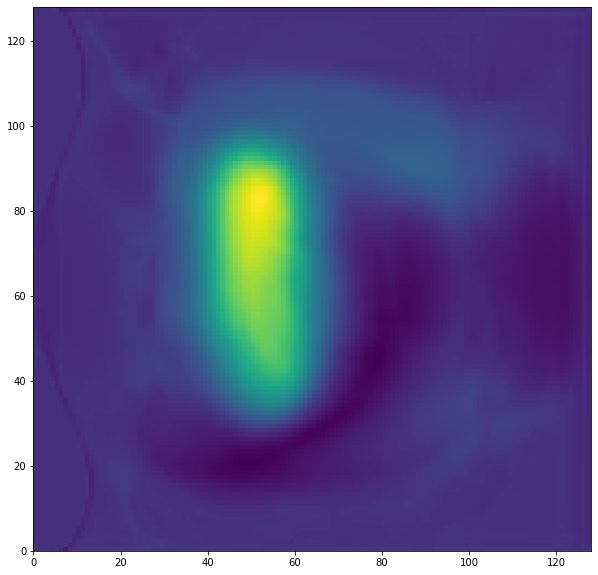

In [84]:
df = pd.DataFrame(heatmaps[0, 970, :, :].numpy())
plt.figure(figsize=(10, 10))
plt.pcolor(df)
plt.show()

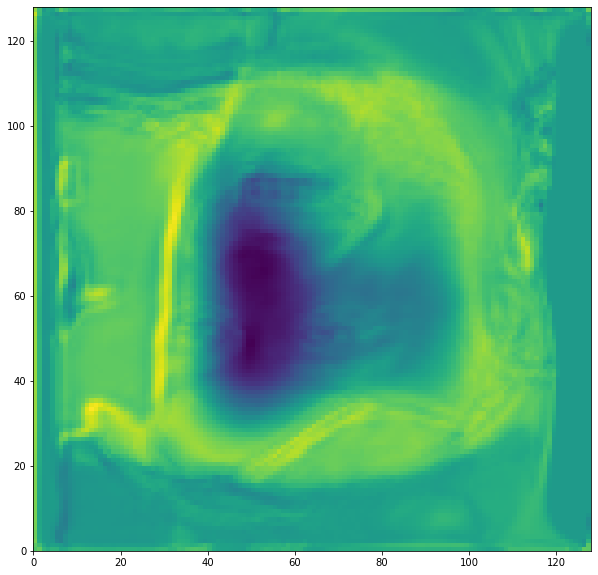

In [30]:
df = pd.DataFrame(heatmaps[1, 0, :, :].numpy())
plt.figure(figsize=(10, 10))
plt.pcolor(df)
plt.show()

In [77]:
df = pd.DataFrame(heatmaps[0, 971, :, :].numpy())
plt.figure(figsize=(10, 10))
plt.pcolor(df)
plt.show()

IndexError: index 971 is out of bounds for dimension 1 with size 971

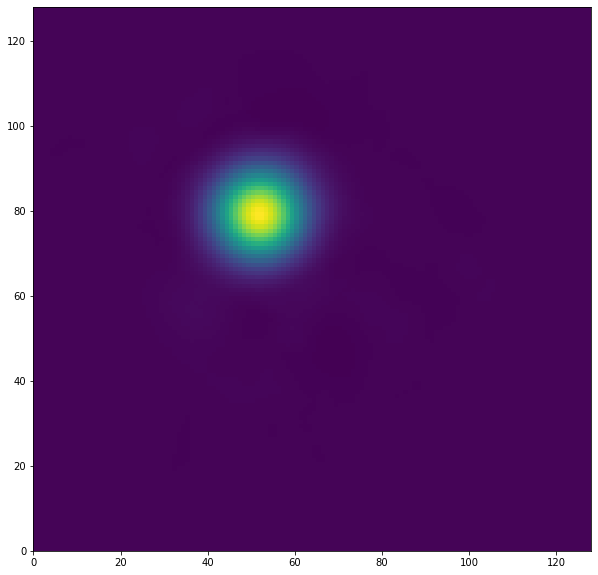

In [31]:
df = pd.DataFrame(heatmaps[0, 970, :, :].numpy())
plt.figure(figsize=(10, 10))
plt.pcolor(df)
plt.show()

In [147]:
from heatmap import landmarks2heatmap, heatmaps2landmarks

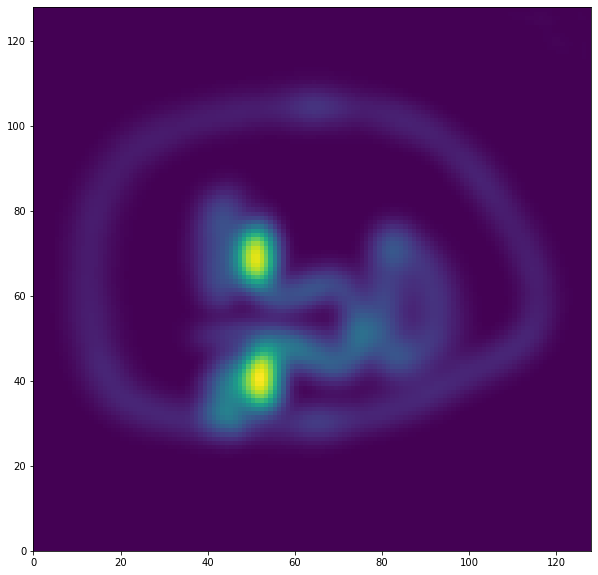

In [82]:
df = pd.DataFrame(torch.sum(heatmaps[1, :, :, :], dim=0).numpy())
plt.figure(figsize=(10, 10))
plt.pcolor(df)
plt.show()

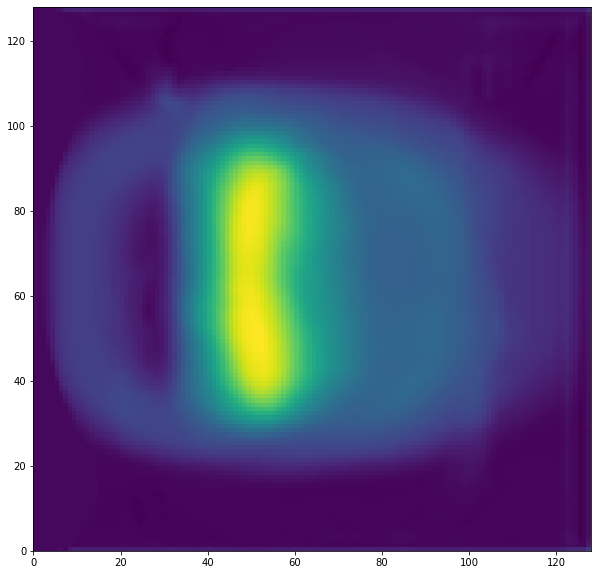

In [65]:
df = pd.DataFrame(torch.sum(heatmaps[0, :, :, :], dim=0).numpy())
plt.figure(figsize=(10, 10))
plt.pcolor(df)
plt.show()

In [58]:
heatmaps.shape

torch.Size([4, 971, 128, 128])

In [110]:
heatmaps[0, 970, :, :].shape

torch.Size([128, 128])

In [140]:
def heatmaps2landmarksNew(heatmaps):
    b, n, d1, d2 = heatmaps.shape
    m = heatmaps.view(b, n, -1).argmax(2)
    x, y = m // d, m % d
    return torch.cat((x[:, :, None], y[:, :, None]), dim=2)

torch.Size([4, 971, 2])


tensor([79, 52])

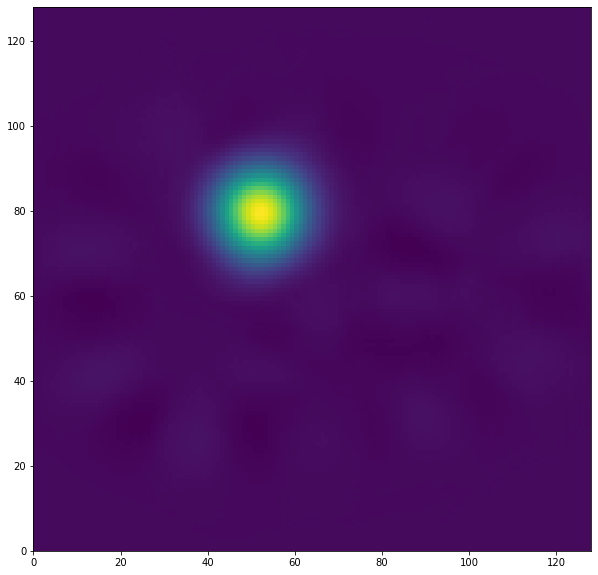

tensor([[79, 52]])


In [106]:
a = heatmaps[0, 970, :, :]

# Рисуем
df = pd.DataFrame(a.numpy())
plt.figure(figsize=(10, 10))
plt.pcolor(df)
plt.show()

n, d = 1, 128
m = a.view(n, -1).argmax(1).view(-1, 1)
indices = torch.cat((m // d, m % d), dim=1)
print(indices)

In [45]:
df = pd.DataFrame(torch.sum(heatmaps2[0, :, :, :], dim=0).numpy())
plt.figure(figsize=(10, 10))
plt.pcolor(df)
plt.show()

IndexError: too many indices for tensor of dimension 3

In [ ]:
test_predictions = predict_unet(model, test_dataloader, device)

In [ ]:
with open('{}_test_predictions.pkl'.format(MODEL_NAME), 'wb') as fp:
    pickle.dump({'image_names': test_dataset.image_names, 'landmarks': test_predictions}, fp)